In [1]:
import pandas as pd
import numpy as np
from KRData.HKData import *
from KRData.util import draw_klines
from ib_insync import *
import datetime as dt
from IPython.display import display, clear_output
import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


d:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
hf = HKFuture('krdata', 'kairuitouzi')

In [3]:
data = hf.get_main_contract_bars('HSI', start='20181201') # 获取需要对照的历史K线

In [4]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1',7496,clientId=9)
hsi1904 = Future('HSI', '201904')
ib.qualifyContracts(hsi1904)
BN=60
FN=60
O=100

In [5]:
mkData = ib.reqHistoricalData(hsi1904, '', f'{60*O} S', '1 min', 'TRADES', useRTH=False, keepUpToDate=True)

In [6]:
def analyze(targetData: pd.DataFrame, sourceData: pd.DataFrame, corrThreshold=0.8):
    targetSize = len(targetData)
    sourceSize = len(sourceData)
    ret = []
    for i in range(sourceSize-targetSize):
        sc = sourceData[i:i+targetSize]
        corr=np.corrcoef(targetData, sc)[0][1]
        ret.append([sc.index[0], sc.index[-1], corr])
    
    gt_threshold = [r for r in ret if r[-1]>corrThreshold]
    
    # 过滤连续K线高相关
    filtedRet = []
    if len(gt_threshold)>=2:
        r=gt_threshold[0]
        for i in range(len(gt_threshold)-1):
            if (gt_threshold[i+1][1] -gt_threshold[i][0])*0.9<=(gt_threshold[i][1] -gt_threshold[i+1][0]):
                r =gt_threshold[i+1] if gt_threshold[i+1][-1]>r[-1] else r
            else:
                filtedRet.append(r)
                r=gt_threshold[i+1]
        else:
            filtedRet.append(r)
    else:
        filtedRet = gt_threshold
        
    return filtedRet

In [11]:
def analyzeHistoricalData(bars, hasNewBar):
    if hasNewBar:
        targetData = util.df(bars[-O:]).rename(columns={'date':'datetime'})
        print('NewBarComing...Calculating!!!')
        result = analyze(targetData.close, data.close, 0.7)
        if len(result) !=0:
            clear_output()
            backwardN = dt.timedelta(minutes=BN)
            forwardN = dt.timedelta(minutes=FN)
            print(f'Get {len(result)} match!!!')
            result.sort(key=lambda x: x[-1], reverse=True)
            startLine = Line2D([BN-1, BN-1],[0,sys.maxsize] )
            endLine = Line2D([O+BN-1, O+BN-1],[0,sys.maxsize] )
            top1 = result[0]
            top2 = result[1]
            top3  = result[2]
            print( f'Top1 Corr:{top1[-1]}')
            cur_bars = draw_klines(targetData)
            display(cur_bars)
            fig1 = draw_klines(data[top1[0]-backwardN:top1[1]+forwardN], extra_lines=[startLine, endLine])
            p1 = exploreInc(data, top1[1])
            display(p1)
            display(fig1)
            fig2 = draw_klines(data[top2[0]-backwardN:top2[1]+forwardN], extra_lines=[startLine, endLine])
            p2 = exploreInc(data, top2[1])
            display(p2)
            display(fig2)
            fig3 = draw_klines(data[top3[0]-backwardN:top3[1]+forwardN], extra_lines=[startLine, endLine])
            p3 = exploreInc(data, top3[1])
            display(p3)
            display(fig3)
        else:
            print("Get No match")

In [8]:
def exploreInc(data:pd.DataFrame, _t: dt.datetime, interval=5):
    n=int(FN/interval)
    _interval = dt.timedelta(minutes=interval)
    _temp = data[_t:_t + _interval*n]
    _p = _temp.asof(_t).close
    _priceList = []
    for i in range(0, n):
        nextN = _temp.asof(_t + _interval*(i+1))
        t = nextN.datetime
        p = nextN.close
        _priceList.append([t,round((p-_p)/_p,6)])
    return _priceList
        

Get 184 match!!!
Top1 Corr:0.9455501422499664


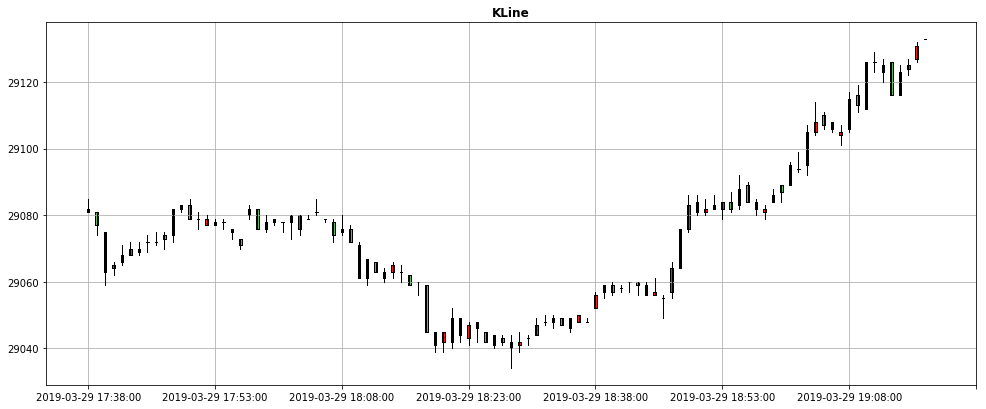

[[Timestamp('2019-02-26 20:32:00'), -0.000243],
 [Timestamp('2019-02-26 20:37:00'), -0.00031199999999999999],
 [Timestamp('2019-02-26 20:42:00'), -0.00027799999999999998],
 [Timestamp('2019-02-26 20:47:00'), -0.00055599999999999996],
 [Timestamp('2019-02-26 20:52:00'), -0.00052099999999999998],
 [Timestamp('2019-02-26 20:57:00'), -3.4999999999999997e-05],
 [Timestamp('2019-02-26 21:02:00'), -3.4999999999999997e-05],
 [Timestamp('2019-02-26 21:07:00'), 0.000174],
 [Timestamp('2019-02-26 21:12:00'), 0.0],
 [Timestamp('2019-02-26 21:17:00'), 6.8999999999999997e-05],
 [Timestamp('2019-02-26 21:22:00'), -0.000417],
 [Timestamp('2019-02-26 21:27:00'), -0.00045100000000000001]]

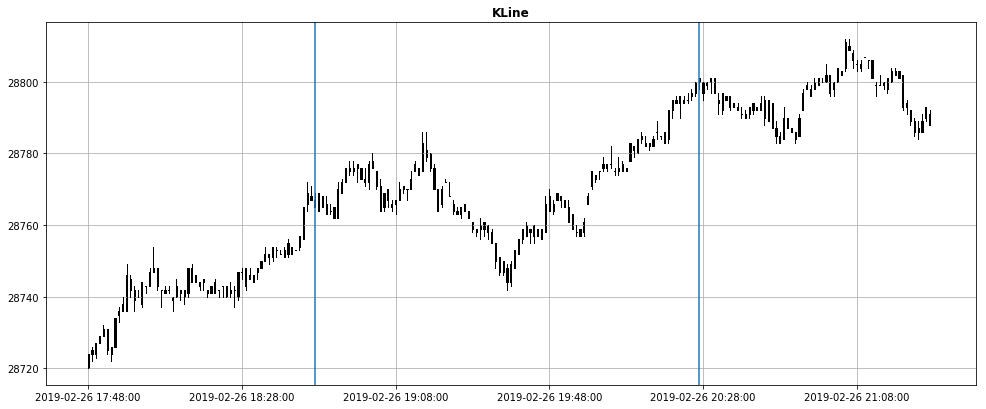

[[Timestamp('2019-02-28 10:26:00'), 0.00051999999999999995],
 [Timestamp('2019-02-28 10:31:00'), 0.000243],
 [Timestamp('2019-02-28 10:36:00'), -0.001039],
 [Timestamp('2019-02-28 10:41:00'), 0.00041599999999999997],
 [Timestamp('2019-02-28 10:46:00'), 0.0011429999999999999],
 [Timestamp('2019-02-28 10:51:00'), 6.8999999999999997e-05],
 [Timestamp('2019-02-28 10:56:00'), -0.00051999999999999995],
 [Timestamp('2019-02-28 11:01:00'), -0.00083100000000000003],
 [Timestamp('2019-02-28 11:06:00'), -0.001836],
 [Timestamp('2019-02-28 11:11:00'), -0.0026329999999999999],
 [Timestamp('2019-02-28 11:16:00'), -0.0030490000000000001],
 [Timestamp('2019-02-28 11:21:00'), -0.003153]]

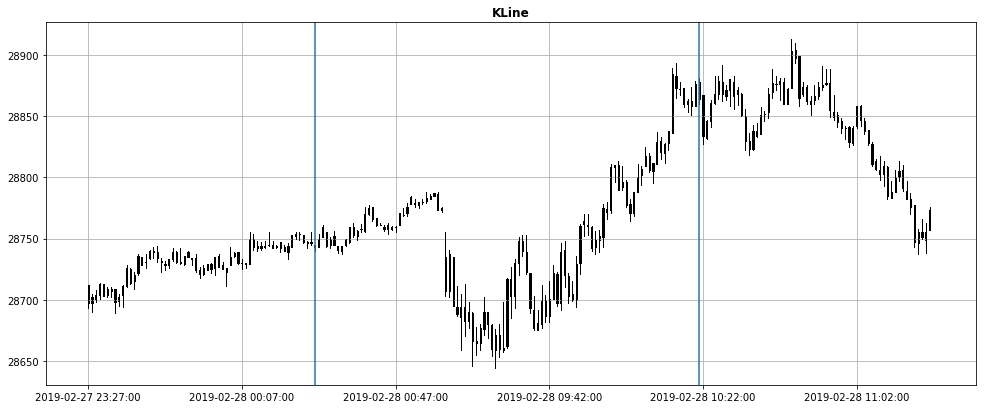

[[Timestamp('2018-12-06 15:33:00'), 0.00015300000000000001],
 [Timestamp('2018-12-06 15:38:00'), 0.00022900000000000001],
 [Timestamp('2018-12-06 15:43:00'), -0.00015300000000000001],
 [Timestamp('2018-12-06 15:48:00'), 3.8000000000000002e-05],
 [Timestamp('2018-12-06 15:53:00'), -0.00019100000000000001],
 [Timestamp('2018-12-06 15:58:00'), 0.00019100000000000001],
 [Timestamp('2018-12-06 16:03:00'), 0.0],
 [Timestamp('2018-12-06 16:08:00'), -0.00022900000000000001],
 [Timestamp('2018-12-06 16:13:00'), -0.00091699999999999995],
 [Timestamp('2018-12-06 16:18:00'), -0.00019100000000000001],
 [Timestamp('2018-12-06 16:23:00'), 0.0],
 [Timestamp('2018-12-06 16:28:00'), -0.00084099999999999995]]

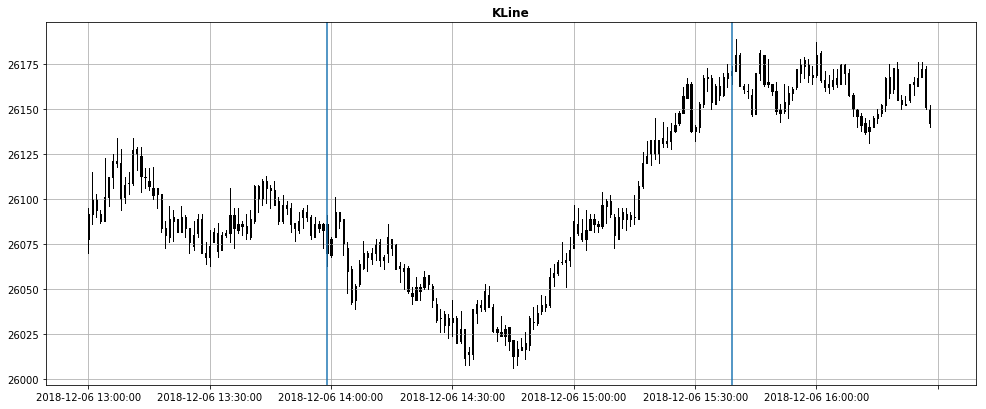

In [12]:
mkData.updateEvent += analyzeHistoricalData